# Model Training
## 1. Data Imports

In [314]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modeling imports
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from catboost import CatBoostRegressor
from xgboost import XGBRegressor

import scipy.stats as stats

In [315]:
# import csv data as pandas dataframe
df = pd.read_csv('data/student_performance.csv')

In [316]:
# show top 5 records
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


## 2. Preprocessing
### `Average Score` as Our Target Variable

In [317]:
# prep X and y variables
X = df.drop(columns=['math score'], axis=1)
y = df['math score']

X.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [318]:
print("Categories in our 'gender' variable:", end=' ')
print(df['gender'].unique())

print("Categories in our 'race/ethnicity' variable:", end=' ')
print(df['race/ethnicity'].unique())

print("Categories in our 'parental level of education' variable:", end=' ')
print(df['parental level of education'].unique())

print("Categories in our 'lunch' variable:", end=' ')
print(df['lunch'].unique())

print("Categories in our 'test preparation course' variable:", end=' ')
print(df['test preparation course'].unique())

Categories in our 'gender' variable: ['female' 'male']
Categories in our 'race/ethnicity' variable: ['group B' 'group C' 'group A' 'group D' 'group E']
Categories in our 'parental level of education' variable: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Categories in our 'lunch' variable: ['standard' 'free/reduced']
Categories in our 'test preparation course' variable: ['none' 'completed']


### 2.1 Transforming Columns

- we need to perform one hot encoding for all categorical columns
- we perform scaling for all numeric columns
- do one hot encoding first and then scaling, which is why we apply them as a pipeline
- ColumnTransformer combines the two (OneHotEncoder and StandardScaler) together

In [319]:
# create Column Transformer with 2 types of transformers
num_features = X.select_dtypes(exclude='object').columns
categorical_features = X.select_dtypes(include='object').columns

num_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ('OneHoteEncoder', oh_transformer, categorical_features),
        ('StandardScaler', num_transformer, num_features),
    ]
)

X = preprocessor.fit_transform(X)
X.shape

(1000, 19)

In [320]:
# split dataset into train and test sets
X_train, X_placeholder, y_train, y_placeholder = train_test_split(X, y, test_size=0.3, random_state=42)
X_eval, X_test, y_eval, y_test = train_test_split(X_placeholder, y_placeholder, test_size=0.5, random_state=42)

print(X_train.shape, X_test.shape)

(700, 19) (150, 19)


In [321]:
# evaluation fxn to easily return all metrics after model training
def evaluate_model(true_vals, predicted_vals):
    mae = mean_absolute_error(true_vals, predicted_vals)
    mse = mean_squared_error(true_vals, predicted_vals)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_vals, predicted_vals)
    return mae, rmse, r2

## 3. Train and Predict

In [322]:
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'K-Neighbors Regressor': KNeighborsRegressor(),
    'Decision Tree': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'CatBoosting Regressor': CatBoostRegressor(verbose=False),
    'AdaBoostRegressor': AdaBoostRegressor()
}

model_list = []
r2_list = []

# iterate through each model
for name, model in models.items():
    # train model on the training data
    model.fit(X_train, y_train)

    # make predictions on the training data
    y_train_pred = model.predict(X_train)

    # make predictions on the evaluation data
    y_eval_pred = model.predict(X_eval)

    # evaluate the model on the train data
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    # evaluate the model on the test data
    model_eval_mae, model_eval_rmse, model_eval_r2 = evaluate_model(y_eval, y_eval_pred)

    print(name)
    model_list.append(name)

    print('Model performance for Training Set')
    print(f'-- Root Mean Squred Error: {model_train_rmse:.4f}')
    print(f'-- Mean Absolute Error: {model_train_mae:.4f}')
    print(f'-- R2 Score: {model_train_r2:.4f}')
    print('-'*35)
    
    print('Model performance for Evaluation Set')
    print(f'-- Root Mean Squred Error: {model_eval_rmse:.4f}')
    print(f'-- Mean Absolute Error: {model_eval_mae:.4f}')
    print(f'-- R2 Score: {model_eval_r2:.4f}')
    r2_list.append(model_eval_r2)

    print('='*35)
    print('\n')

Linear Regression
Model performance for Training Set
-- Root Mean Squred Error: 5.2483
-- Mean Absolute Error: 4.1984
-- R2 Score: 0.8751
-----------------------------------
Model performance for Evaluation Set
-- Root Mean Squred Error: 5.6643
-- Mean Absolute Error: 4.5163
-- R2 Score: 0.8938


Lasso
Model performance for Training Set
-- Root Mean Squred Error: 6.5106
-- Mean Absolute Error: 5.1582
-- R2 Score: 0.8078
-----------------------------------
Model performance for Evaluation Set
-- Root Mean Squred Error: 7.4174
-- Mean Absolute Error: 5.9252
-- R2 Score: 0.8179


Ridge
Model performance for Training Set
-- Root Mean Squred Error: 5.2487
-- Mean Absolute Error: 4.1977
-- R2 Score: 0.8751
-----------------------------------
Model performance for Evaluation Set
-- Root Mean Squred Error: 5.6708
-- Mean Absolute Error: 4.5186
-- R2 Score: 0.8936


K-Neighbors Regressor
Model performance for Training Set
-- Root Mean Squred Error: 5.6784
-- Mean Absolute Error: 4.5037
-- R2 Sc

## 4. Results

In [323]:
# zip together model_list and r2_list
models_r2 = zip(model_list, r2_list)

# turn into pd df
results = pd.DataFrame(models_r2, columns=['Model Name', 'R2 Score'])

# sort by r2 score
results = results.sort_values(by='R2 Score', ascending=False)
results

,Model Name,R2 Score
0,Linear Regression,0.893832
2,Ridge,0.893587
6,CatBoosting Regressor,0.862769
4,Decision Tree,0.861673
7,AdaBoostRegressor,0.843894
5,XGBoost,0.837914
1,Lasso,0.817942
3,K-Neighbors Regressor,0.782083


#### Insights

- Ridge Regression and Linear Regression have the best test set performance, with an R2 score of 88.06% and 88.04% respectively
- since their performace is so close, we will use Linear Regression for ease of interpretation

### 4.1 Train Final Model on Test Set

In [324]:
# initialize final model
final_model = LinearRegression(fit_intercept=True)

final_X_train = np.vstack((X_train, X_eval))
final_y_train = np.concatenate((y_train, y_eval))

# train final model on train data
final_model.fit(final_X_train, final_y_train)

# predict final model on train data
y_test_pred = final_model.predict(X_test)

# evaluate final model on train data
final_test_mae, final_test_rmse, final_test_r2 = evaluate_model(y_test, y_test_pred)

print('Final Model: Linear Regression')
print('Model Performance for Test Set')
print(f'-- Root Mean Squared Error: {final_test_mae:.4f}')
print(f'-- Mean Absolute Error: {final_test_rmse:.4f}')
print(f'-- R2 Score: {final_test_r2:.4f}')

Final Model: Linear Regression
Model Performance for Test Set
-- Root Mean Squared Error: 4.3539
-- Mean Absolute Error: 5.4684
-- R2 Score: 0.8470


### 4.2 Parity Plot

A parity plot, also known as a 1:1 plot, compares the predicted values to the actual values. We want the points in this scatter plot to lie as close to the `y = x` line as possible, which indicates perfect prediction accuracy. This plots helps us to assess how well the model performed, since we are able to see how well the predictions match the actual values.

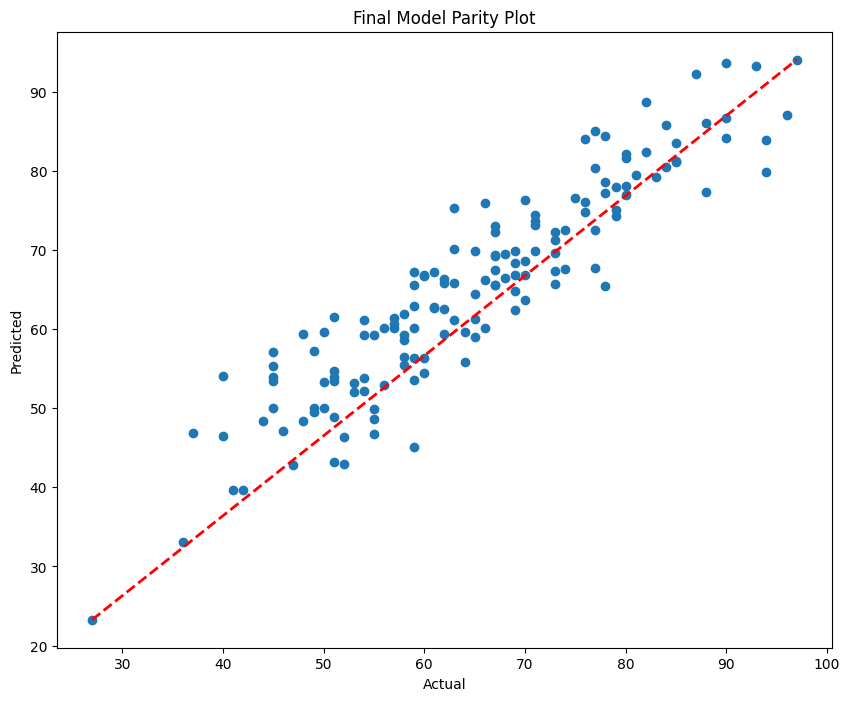

In [325]:
plt.figure(figsize=(10, 8))

plt.scatter(y_test, y_test_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Final Model Parity Plot')

# add a y = x line for reference
plt.plot([y_test.min(), y_test.max()], [y_test_pred.min(), y_test_pred.max()], 'r--', lw=2)

plt.show()

### 4.3 Residual Plot

A residual plot shows the difference between the actual values and the predicted values – the residuals. This plot helps us identify patterns in the residuals that might indicate model issues, such as non-linearity or heteroscedasticity.

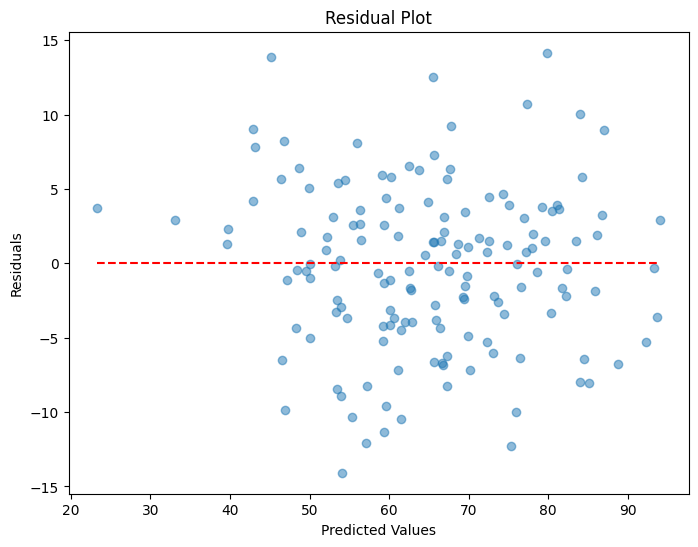

In [326]:
plt.figure(figsize=(8, 6))

residuals = y_test - y_test_pred

plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.hlines(0, xmin=y_test_pred.min(), xmax=y_test_pred.max(), colors='red', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.show()

#### Insights

- a random distribution of residuals around the horizontal line at 0 indicates a good fit, as seen above
- we want to avoid any noticeable patterns or trends in the residual plot, since those might suggest issues with out model

### 4.4 Distribution Plot of Residuals

This plot will help use visualize the distribution of residuals. If our model is a good fit, the residuals will follow a normal distribution, meaning the errors in the model are normally distributed.

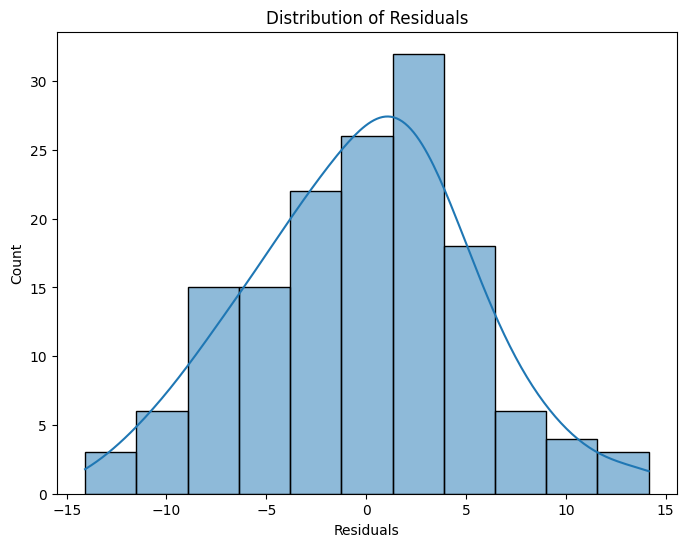

In [327]:
plt.figure(figsize=(8, 6))

sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')

plt.show()

#### Insights

- as we can see above, our residuals follow a fairly normal distribution, meaning our model's errors are randomly distributed (which is good!)
- deviations from a normal distribution could indicate problems with our model OR indicate the presence of outliers

### 4.5 Q-Q Plot (Quantile-Quantile Plot)

A Q-Q plot helps us check if the residuals are normally distributed. In these plots, we compare their quantiles against a normal distribution.

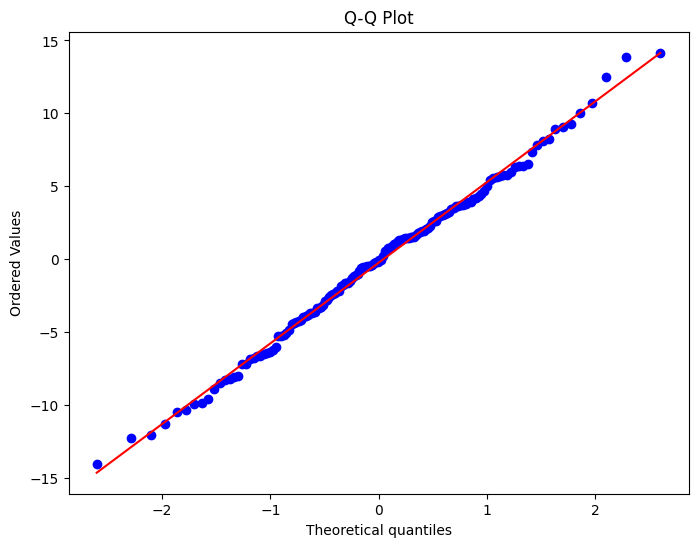

In [328]:
plt.figure(figsize=(8, 6))

stats.probplot(residuals, dist='norm', plot=plt)
plt.title('Q-Q Plot')

plt.show()

#### Insights

- as we can see above, the residuals fall very close to the reference long, highlighting again that they are normally distributed

### 4.6 Scatter Plot of Actual vs. Predicted Values with Color by Residual

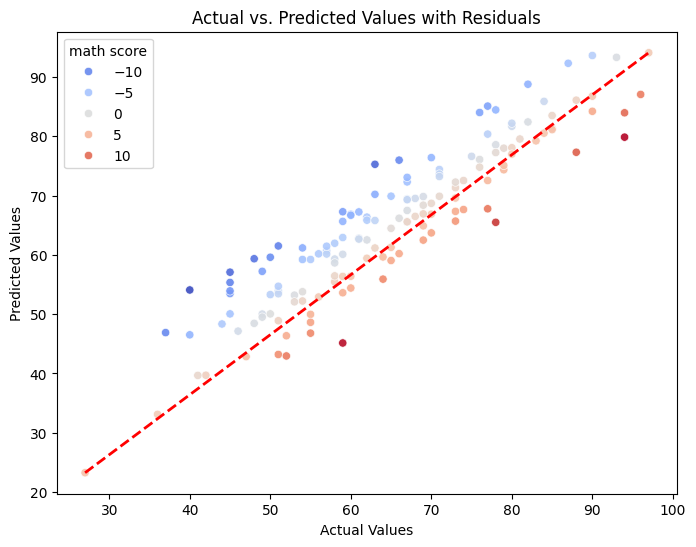

In [329]:
plt.figure(figsize=(8, 6))


sns.scatterplot(x=y_test, y=y_test_pred, hue=residuals, palette='coolwarm', alpha=0.9)
plt.plot([y_test.min(), y_test.max()], [y_test_pred.min(), y_test_pred.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values with Residuals')

plt.show()

#### Insights

- the plot above lets us visualize the magnitude of the residuals using color
- blue represents negative residuals – underestimation
- red represents positive residuals – overestimation